In [20]:
import matplotlib.pyplot as plt
#%matplotlib widget
from ipywidgets import *
import numpy as np
import sys

In [21]:
import taurex.log
taurex.log.disableLogging()
from taurex.cache import OpacityCache,CIACache

path_to_data = ''
OpacityCache().clear_cache()
OpacityCache().set_opacity_path(f"atmosphere/xsecs")
CIACache().set_cia_path(f"atmosphere/cia/hitran")

from taurex.temperature import Guillot2010
guillot = Guillot2010(T_irr=1415.0)

from taurex.planet import Planet
planet = Planet(planet_radius=1.39,planet_mass=0.58)

from taurex.stellar import BlackbodyStar

star = BlackbodyStar(temperature=6230.0,radius=1.28)

from taurex.chemistry import TaurexChemistry
chemistry = TaurexChemistry(fill_gases=['H2','He'],ratio=0.172)

from taurex.chemistry import ConstantGas
chemistry.addGas(ConstantGas('H2O',mix_ratio=10**np.random.uniform(-2,-8)))
chemistry.addGas(ConstantGas('CH4',mix_ratio=10**np.random.uniform(-2,-8)))
chemistry.addGas(ConstantGas('CO2',mix_ratio=10**np.random.uniform(-2,-8)))
chemistry.addGas(ConstantGas('CO',mix_ratio=10**np.random.uniform(-2,-8)))

In [27]:
from taurex.model import TransmissionModel
tm = TransmissionModel(planet=planet,
                       temperature_profile=guillot,
                       chemistry=chemistry,
                       star=star,
                        atm_min_pressure=1e-0,
                       atm_max_pressure=1e6,
                       nlayers=30)

from taurex.contributions import AbsorptionContribution
tm.add_contribution(AbsorptionContribution())

from taurex.contributions import CIAContribution
tm.add_contribution(CIAContribution(cia_pairs=['H2-H2','H2-He']))

from taurex.contributions import RayleighContribution
tm.add_contribution(RayleighContribution())



In [28]:
tm.build()
res = tm.model()

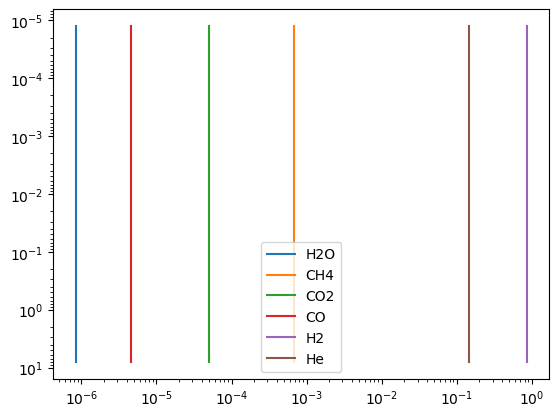

In [29]:
plt.figure()

for x,gasname in enumerate(tm.chemistry.activeGases):
    
    plt.plot(tm.chemistry.activeGasMixProfile[x],tm.pressureProfile/1e5,label=gasname)
for x,gasname in enumerate(tm.chemistry.inactiveGases):
    
    plt.plot(tm.chemistry.inactiveGasMixProfile[x],tm.pressureProfile/1e5,label=gasname)
plt.gca().invert_yaxis()
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

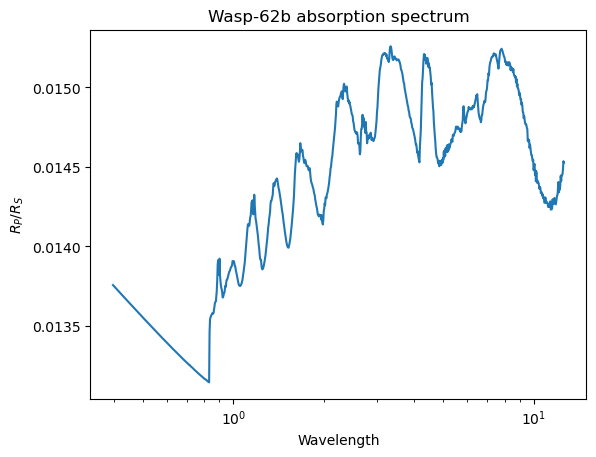

In [30]:
from taurex.binning import FluxBinner,SimpleBinner
binned_fig = plt.figure()


#Make a logarithmic grid
wngrid = np.sort(10000/np.logspace(-0.4,1.1,1000))
bn = SimpleBinner(wngrid=wngrid)

bin_wn, bin_rprs,_,_  = bn.bin_model(tm.model(wngrid=wngrid))

plt.title('Wasp-62b absorption spectrum')
plt.plot(10000/bin_wn,bin_rprs)
plt.xscale('log')
plt.xlabel('Wavelength')
plt.ylabel('$R_{P}/R_{S}$')
plt.show()